In [42]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

In [43]:
image = cv.imread("./code0 (2) (1) (3).tif", 0)

assert image is not None, "file could not be read, check with os.path.exists()"

## histogramme

In [44]:
def showHist(image):
    if image.ndim == 2:
        fig, axes = plt.subplots(1, 2, figsize=(9, 4))
        histr = cv.calcHist([image], [0], None, [256], [0, 256]).flatten()
        axes[1].bar(range(len(histr)), histr)
        axes[1].set_xlim([0, 256])
        axes[0].imshow(image, cmap="gray")
        axes[0].set_axis_off()
    else:
        color = ("b", "g", "r")
        for i, col in enumerate(color):
            histr = cv.calcHist([image], [i], None, [256], [0, 256])
            plt.plot(histr, color=col)
            plt.xlim([0, 256])
    plt.show()

## Binarisation

In [45]:

def binarize(image):
    tresh, img = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    return tresh, img.astype("uint8")

def showBinary(image):
    tresh, binary_img = binarize(image)
    plt.imshow(binary_img, cmap="gray")
    plt.title(f"Binarized image with a threshold value of {tresh}")
    plt.axis("off")
    plt.show()


## Erosion

In [46]:

def enhance_img(image):
    kernel = np.ones((5, 5), np.uint8)
    image_erode = cv.erode(image, kernel, iterations=1)
    return image_erode


In [47]:
# Appliquer l'amélioration de l'image
eroded_image = enhance_img(binarize(image)[1])

## Identification des region de l'image

In [48]:

def connectedRegion(image):
    num_labels, labels = cv.connectedComponents(image)

    output = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    digits = []
    for label in range(1, num_labels):
        mask = (labels == label).astype("uint8") * 255

        coords = cv.findNonZero(mask)

        x_min, y_min = coords[:, 0, 0].min(), coords[:, 0, 1].min()
        x_max, y_max = coords[:, 0, 0].max(), coords[:, 0, 1].max()

        # Dessiner un rectangle autour de chaque région
        cv.rectangle(output, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        digits.append(mask[y_min:y_max, x_min:x_max])
    return output, digits


In [49]:
from typing import List

def show_digits(digits: List[np.ndarray]):
    num_digits = len(digits)
    fig, axes = plt.subplots(1, num_digits)
    for idx, digit in enumerate(digits):
        axes[idx].imshow(digit, cmap="gray")


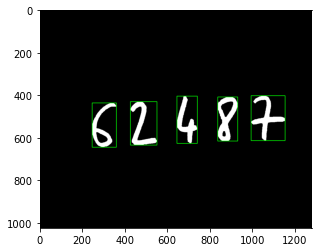

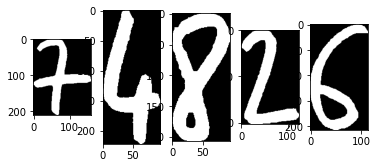

In [50]:

# Détecter et afficher les régions connectées
regions_image, digits = connectedRegion(eroded_image)
plt.imshow(regions_image)
# plt.show()
show_digits(digits)


## Dilatation 

In [51]:


def dilate_img(img: np.ndarray):

    V, H = img.shape

    horizontal_size = 2 * H + 1
    vertical_size = 2 * V + 1

    kernel_horizontal = np.zeros((1, horizontal_size), dtype=np.uint8)
    kernel_horizontal[0, :H] = 1

    kernel_vertical = np.zeros((vertical_size, 1), dtype=np.uint8)
    kernel_vertical[:V, 0] = 1

    dilated_east = cv.dilate(img, kernel_horizontal, iterations=1)
    dilated_west = cv.dilate(img, np.flip(kernel_horizontal, axis=1), iterations=1)

    dilated_north = cv.dilate(img, kernel_vertical, iterations=1)
    dilated_south = cv.dilate(img, np.flip(kernel_vertical, axis=0), iterations=1)

    return {
        "east": dilated_east.astype("uint8"),
        "west": dilated_west.astype("uint8"),
        "south": dilated_south.astype("uint8"),
        "north": dilated_north.astype("uint8"),
    }


In [52]:
dilated_dict = dilate_img(digits[-1])

## Trouver les cavités

In [53]:
from typing import Dict

def find_calvitie(digit: np.ndarray, morph_dict: Dict[str, np.ndarray]):
    east_cavitie = (
        morph_dict["east"]
        & (255 - morph_dict["west"])
        & morph_dict["south"]
        & morph_dict["north"]
        & (255 - digit)
    )
    return east_cavitie


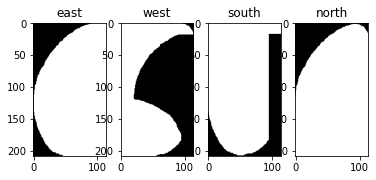

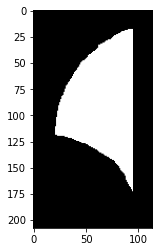

In [54]:
fig, axes = plt.subplots(1, len(dilated_dict))
for ax, (key, mat) in zip(axes, dilated_dict.items()):
    ax.imshow(mat, cmap="gray")
    ax.set_title(key)
plt.show()
plt.imshow(find_calvitie(digits[-1], dilated_dict), cmap="gray")
plt.show()